In [1]:
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute
from qiskit.circuit import Gate, ControlledGate
from qiskit.visualization import plot_histogram, plot_state_qsphere
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Operator
%matplotlib inline

In [2]:
event_sim = Aer.get_backend('qasm_simulator')
state_sim = Aer.get_backend('statevector_simulator')

### Generating a GHZ state

In [3]:
qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(3, 'c')

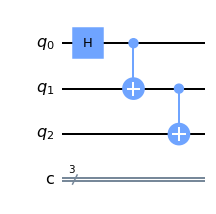

In [4]:
ghz_circuit = QuantumCircuit(qr, cr)
ghz_circuit.h(qr[0])
ghz_circuit.cx(qr[0], qr[1])
ghz_circuit.cx(qr[1], qr[2])

ghz_circuit.draw(output = 'mpl')

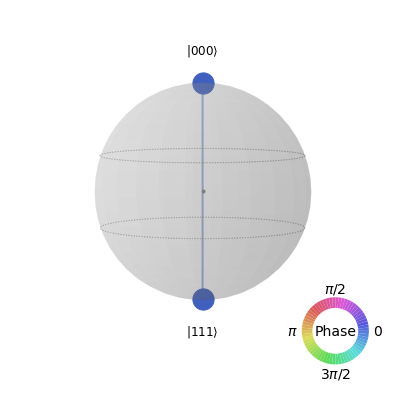

In [5]:
final_state = execute(ghz_circuit, backend = state_sim).result()
plot_state_qsphere(final_state.get_statevector())

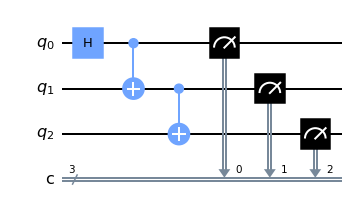

In [6]:
ghz_circuit.measure(qr, cr)
ghz_circuit.draw(output = 'mpl')

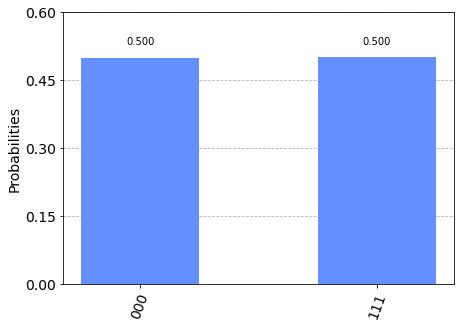

In [7]:
event_results = execute(ghz_circuit, backend = event_sim, shots = 800000).result()
plot_histogram(event_results.get_counts())

### Deutsch Algorithm

In [8]:
def deutschOracle(circuit, qubit, oracle_type, ctrl_qubit = None):
    if (oracle_type not in ['constant', 'balanced']):
        raise AttributeError("'oracle_type' value must be: 'constant' or 'balanced'")
    coin_flip = np.random.randint(2)
    
    if (oracle_type == 'constant'):
        if (coin_flip == 0):
            print('oracle function: f(x) = 0')
            return circuit.i(qubit)
        else:
            print('oracle function: f(x) = 1')
            return circuit.x(qubit)
    elif (oracle_type == 'balanced'):
        if (ctrl_qubit == None):
            raise AttributeError('Balanced oracles request a control qubit.')
        
        if (coin_flip == 0):
            print('oracle function: f(x) = x')
            return circuit.cx(ctrl_qubit, qubit)
        else:
            print('oracle function: f(x) = (x + 1) mod 2')
            circuit.x(qubit)
            return circuit.cx(ctrl_qubit, qubit)

oracle function: f(x) = (x + 1) mod 2


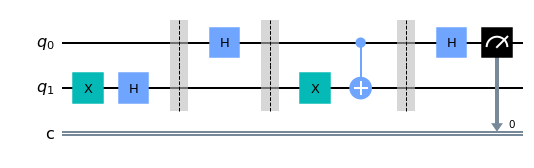

In [11]:
deutsch = QuantumCircuit(2, 1)
deutsch.x(1)
deutsch.h(1)
deutsch.barrier()
deutsch.h(0)
deutsch.barrier()
deutschOracle(deutsch, ctrl_qubit = 0, qubit = 1, oracle_type = 'balanced')
deutsch.barrier()
deutsch.h(0)
deutsch.measure(0, 0)

deutsch.draw(output = 'mpl')

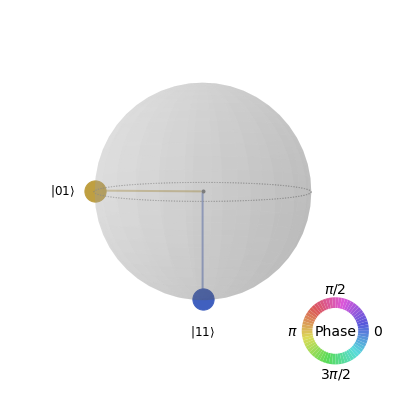

In [12]:
plot_state_qsphere((execute(deutsch, backend = state_sim).result()).get_statevector())

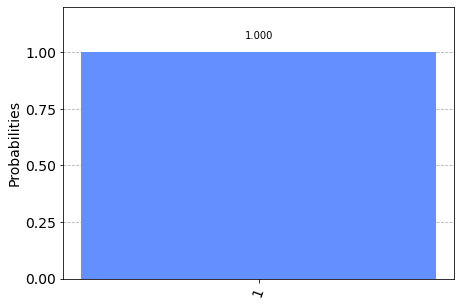

In [13]:
plot_histogram((execute(deutsch, backend = event_sim).result()).get_counts())

### Deutsch-Jozsa Algorithm

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


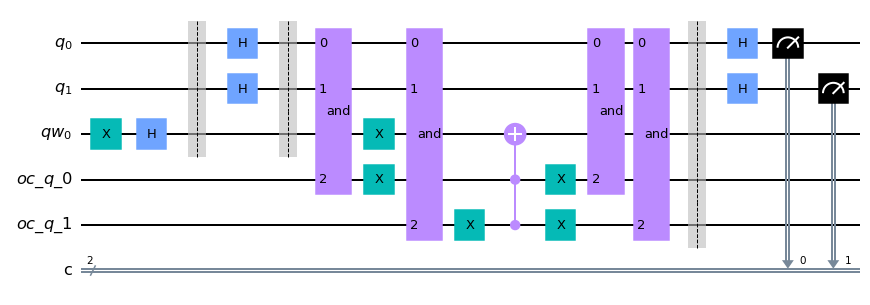

In [14]:
from qiskit.aqua.components.oracles import LogicalExpressionOracle
orc = LogicalExpressionOracle('a XOR b', optimization = False)

n_dj = len(orc.variable_register)
control_qr_dj = QuantumRegister(n_dj, 'q')
working_qr_dj = QuantumRegister(1, 'qw')
cr_dj = ClassicalRegister(n_dj, 'c')

deutsch_jozsa = QuantumCircuit(control_qr_dj, working_qr_dj, cr_dj)
deutsch_jozsa.x(working_qr_dj)
deutsch_jozsa.h(working_qr_dj)
deutsch_jozsa.barrier()
deutsch_jozsa.h(control_qr_dj)
deutsch_jozsa.barrier()

len_anc = 0
len_extra_q = 0
anc_idx = []
extra_q_idx = []

if (orc.ancillary_register != None):
    len_anc = len(orc.ancillary_register)

q_oracle_len = len(orc.circuit.qubits) - len_anc
if (q_oracle_len > n_dj + 1):
    len_extra_q = q_oracle_len - (n_dj + 1)
    extra_q_idx = list(range(n_dj + 1, n_dj + 1 + len_extra_q))
    deutsch_jozsa.add_register(QuantumRegister(len_extra_q, 'oc_q'))
    
if (orc.ancillary_register != None):
    anc_idx = list(range(n_dj + 1 + len_extra_q, n_dj + 1 + len_extra_q + len_anc))
    deutsch_jozsa.add_register(orc.ancillary_register)

var_idx = list(range(0, n_dj))
out_idx = list(range(n_dj, n_dj + 1))
compose_indexing = var_idx + extra_q_idx + out_idx + anc_idx

deutsch_jozsa.compose(orc.construct_circuit(),
                      compose_indexing,
                      inplace = True)
# for indx in range(0, n_dj):
#     deutsch_jozsa.cx(control_qr_dj[indx], working_qr_dj)

deutsch_jozsa.barrier()
deutsch_jozsa.h(control_qr_dj)
deutsch_jozsa.measure(control_qr_dj, cr_dj)

deutsch_jozsa.draw(output = 'mpl')

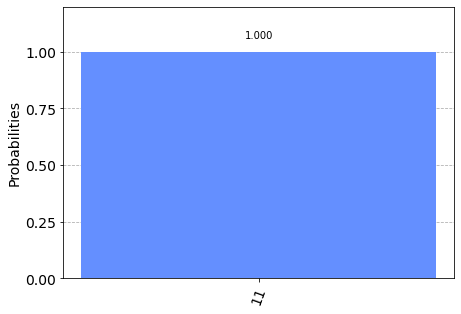

In [15]:
plot_histogram((execute(deutsch_jozsa, backend = event_sim).result()).get_counts())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/qiskit/aqua/algorithms/education/deutsch_jozsa.py:100: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  self._circuit = qc_preoracle + qc_oracle + qc_postoracle
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:933: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


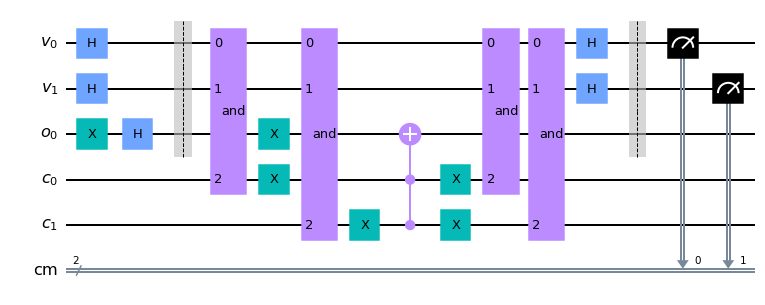

In [16]:
from qiskit.aqua.algorithms import DeutschJozsa

dj_circuit = DeutschJozsa(orc).construct_circuit()

measure_reg = ClassicalRegister(len(orc.variable_register), 'cm')
dj_circuit.add_register(measure_reg)
dj_circuit.measure(orc.variable_register, measure_reg)

dj_circuit.draw('mpl')

### Quantum Spy Hunter

In [17]:
def randomBit():
    rb_circuit = QuantumCircuit(1, 1)
    rb_circuit.h(0)
    rb_circuit.measure(0, 0)
    measurement = execute(rb_circuit, backend = event_sim, shots = 1).result()
    return int(list(set(measurement.get_counts()))[0])

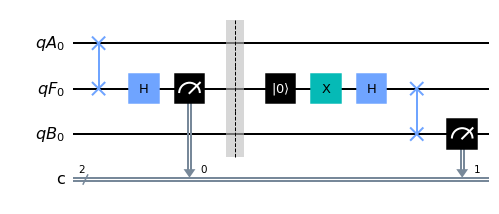

In [33]:
alice_reg = QuantumRegister(1, 'qA')
fiber_reg = QuantumRegister(1, 'qF')
bob_reg = QuantumRegister(1, 'qB')
meas_reg = ClassicalRegister(2, 'c')

# Alice random bits
random_bit_A = randomBit()
random_bit_B = randomBit()

transmission_line = QuantumCircuit(alice_reg, fiber_reg, bob_reg, meas_reg)

if (random_bit_A):
    transmission_line.x(alice_reg)
    
if (random_bit_B):
    transmission_line.h(alice_reg)

transmission_line.swap(alice_reg, fiber_reg)

#### spy ####
transmission_line.h(fiber_reg)
transmission_line.measure(fiber_reg, meas_reg[0])

transmission_line.barrier()
transmission_line.reset(fiber_reg)
transmission_line.x(fiber_reg)
transmission_line.h(fiber_reg)
#############

random_bit_C = randomBit() # Bob random bit

transmission_line.swap(fiber_reg, bob_reg)

if (random_bit_C):
    transmission_line.h(bob_reg)
    
transmission_line.measure(bob_reg, meas_reg[1])

transmission_line.draw('mpl')

In [34]:
sim_result = execute(transmission_line, backend = event_sim, shots = 1).result()
bob_measurement = int((list(sim_result.get_counts())[0])[0])

if (random_bit_B == random_bit_C):
    print("Bob's measurement: " + str(bob_measurement))
    print("Random bit A: " + str(random_bit_A))
    if (bob_measurement != random_bit_A):
        print('\n' + 'There is a spy!')

Bob's measurement: 1
Random bit A: 0

There is a spy!


### Mach-Zehnder Interferometer

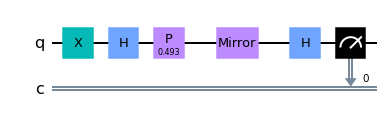

In [35]:
from math import pi
mz_circuit = QuantumCircuit(1, 1)
phi = np.random.uniform(0, pi)

mz_circuit.x(0)
mz_circuit.h(0)
mz_circuit.p(phi, 0)

mirror = UnitaryGate(Operator([[-1,0],[0,-1]]), label='Mirror')
mz_circuit.append(mirror, [0])

mz_circuit.h(0)
mz_circuit.measure(0, 0)

mz_circuit.draw('mpl')

Estimated phi: 0.49070679972034514
Actual phi: 0.49261045640390505


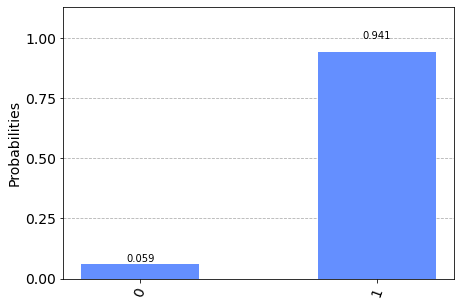

In [36]:
mz_counts = (execute(mz_circuit, backend = event_sim, shots = 100000).result()).get_counts()

if ('0' in set(mz_counts) and '1' in set(mz_counts)):
    print("Estimated phi: "
          + str(2 * np.arctan2(np.sqrt(mz_counts['0']), np.sqrt(mz_counts['1']))))
    print("Actual phi: " + str(phi))

plot_histogram(mz_counts)

### Grover's Algorithm

In [37]:
def encoding_desired_bit_string(bit_str, quant_circuit):
    for idx in range(quant_circuit.num_qubits - 1):
        int_repr = int(bit_str[idx])

        if not int_repr:
            quant_circuit.x(idx)

def apply_uf_gate(desired_string, quantum_circuit):
    encoding_desired_bit_string(desired_string, quantum_circuit)
    quantum_circuit.mct(quantum_circuit.qregs[0], quantum_circuit.qregs[1])
    encoding_desired_bit_string(desired_string, quantum_circuit)

def ground_state_diffusion(quant_circuit, qregister):
    quant_circuit.x(qregister)

    num_qbits_regs = qregister.size
    complex_id = UnitaryGate(Operator(np.identity(2) * np.complex(0,1)), label=r'$iI$')
    neg_complex_id = UnitaryGate(Operator(np.identity(2) * np.complex(0,-1)), label=r'$-iI$')

    quant_circuit.append(complex_id, [0])
    quant_circuit.h(num_qbits_regs - 1)
    quant_circuit.mct(list(range(num_qbits_regs - 1)), num_qbits_regs - 1)
    quant_circuit.append(neg_complex_id, [0])
    quant_circuit.h(num_qbits_regs - 1)

    quant_circuit.x(qregister)

def apply_diffusion_operator(quantum_circuit):
    primary_register = quantum_circuit.qregs[0]
    quantum_circuit.h(primary_register)
    ground_state_diffusion(quantum_circuit, primary_register)
    quantum_circuit.h(primary_register)


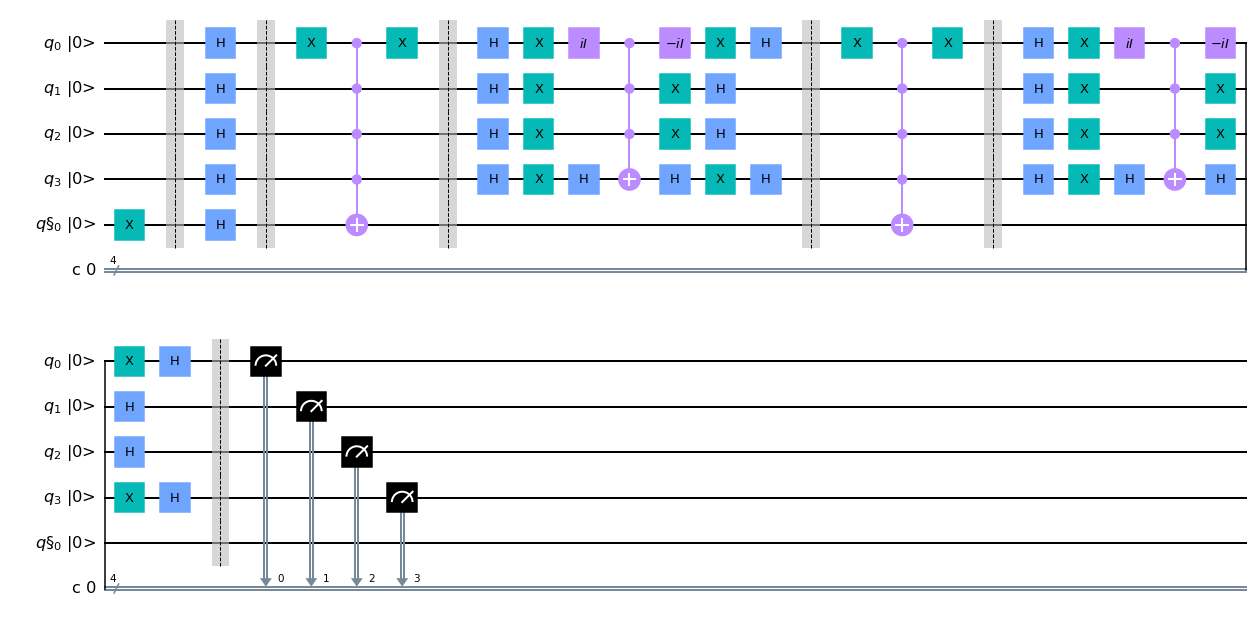

In [38]:
num_qbits = 4
bit_string_target = '0111'
first_qregister = QuantumRegister(num_qbits, 'q')
second_qregister = QuantumRegister(1, 'q§')
cregister = ClassicalRegister(num_qbits, 'c')

grover_qc = QuantumCircuit(first_qregister, second_qregister, cregister)

grover_qc.x(second_qregister)
grover_qc.barrier()
grover_qc.h(grover_qc.qubits)
grover_qc.barrier()

iter_num = 2
for _ in range(iter_num):
    ################ Grover's operator ################
    apply_uf_gate(bit_string_target, grover_qc)
    grover_qc.barrier()
    apply_diffusion_operator(grover_qc)
    grover_qc.barrier()
    ###################################################

grover_qc.measure(first_qregister, cregister)

grover_qc.draw('mpl', initial_state=True)

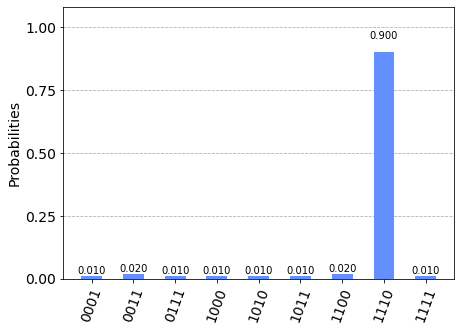

In [39]:
grover_run_res = execute(grover_qc, backend=event_sim, shots=100).result().get_counts()
plot_histogram(grover_run_res)

### to-do list
#### > Teleportation (several algorithms...)
#### > Simon's Algorithm
#### > Shor's Algorithm
#### > Quantum error-correcting code